In [22]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

torch.manual_seed(42)

transform = T.Compose([
    T.ToTensor(),           # converts image pixels to tensor
    T.Normalize([0.5], 0.5) # normalizes the values to the range [-1, 1]
])

In [23]:
train_set = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=transform
)

test_set = torchvision.datasets.FashionMNIST(
    root=".",
    train=False,
    download=True,
    transform=transform
)

In [24]:
text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

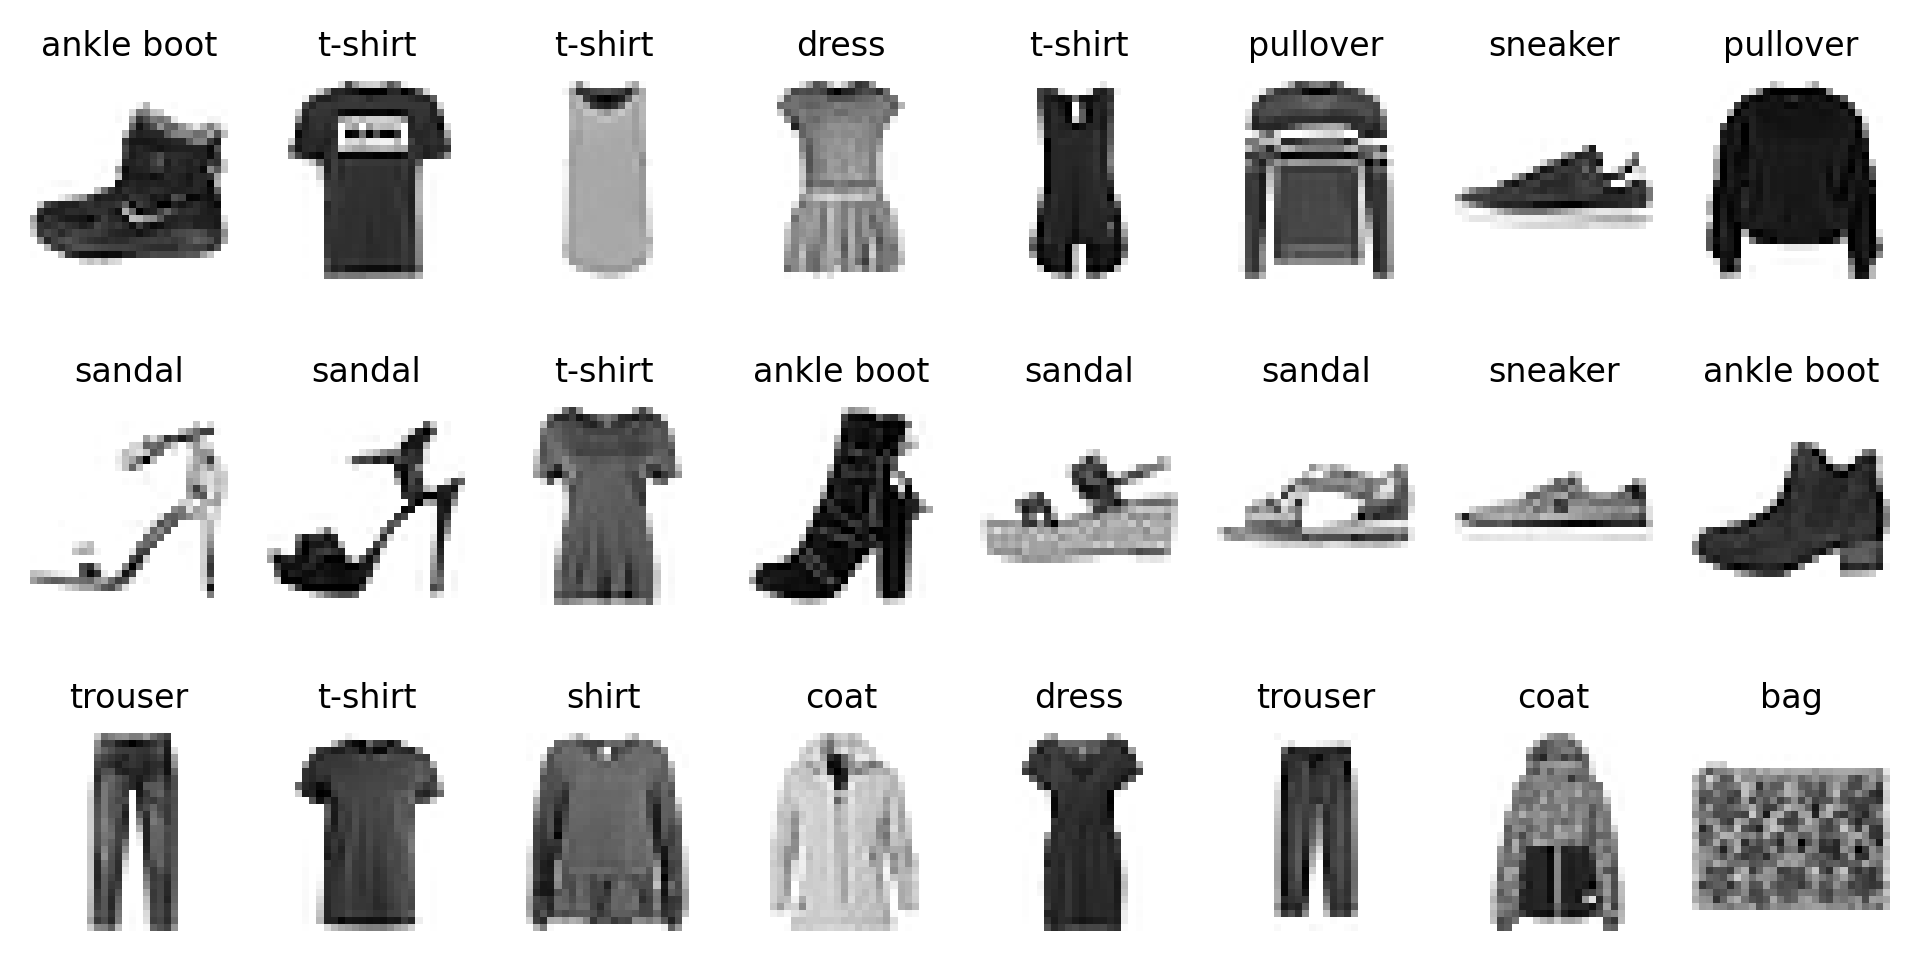

In [25]:
import matplotlib.pyplot as plt

plt.figure(dpi=300,figsize=(8,4))
for i in range(24):
    ax=plt.subplot(3, 8, i + 1)
    img=train_set[i][0]
    img=img/2+0.5
    img=img.reshape(28, 28)
    plt.imshow(img, cmap="binary")
    plt.axis('off')
    plt.title(text_labels[train_set[i][1]], fontsize=8)
plt.show()

In [26]:
train_set, val_set=torch.utils.data.random_split(train_set,[50000,10000])

In [27]:
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=True
)

In [29]:
class EarlyStop:
    def __init__(self, patience=10):
        self.patience = patience
        self.steps = 0
        self.min_loss = float('inf')

    def stop(self, val_loss):
        if val_loss < self.min_loss:
            self.min_loss = val_loss
            self.steps = 0
        elif val_loss >= self.min_loss:
            self.steps += 1
        if self.steps >= self.patience:
            return True
        else:
            return False
        
stopper=EarlyStop()

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model=nn.Sequential(
    nn.Linear(28*28,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128,64),
    nn.ReLU(),
    nn.Linear(64,10)
).to(device)

In [31]:
lr=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
loss_fn=nn.CrossEntropyLoss()

In [32]:
def train_epoch():
    tloss = 0
    for n,(imgs,labels) in enumerate(train_loader):
        imgs = imgs.reshape(-1,28*28).to(device)
        labels = labels.reshape(-1,).to(device)
        preds = model(imgs)
        loss = loss_fn(preds,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tloss+=loss.detach()
    return tloss/n

In [33]:
def val_epoch():
    vloss=0
    for n,(imgs,labels) in enumerate(val_loader):
        imgs=imgs.reshape(-1,28*28).to(device)
        labels=labels.reshape(-1,).to(device)
        preds=model(imgs)
        loss=loss_fn(preds,labels)
        vloss+=loss.detach()
    return vloss/n

In [34]:
for i in range(1,101):
    tloss = train_epoch()
    vloss = val_epoch()
    print(f"at epoch {i}, tloss is {tloss}, vloss is {vloss}")
    if stopper.stop(vloss) == True:
        break

at epoch 1, tloss is 0.5381468534469604, vloss is 0.409934401512146
at epoch 2, tloss is 0.3846866488456726, vloss is 0.40623968839645386
at epoch 3, tloss is 0.3453591465950012, vloss is 0.38351869583129883
at epoch 4, tloss is 0.32199013233184814, vloss is 0.34563952684402466
at epoch 5, tloss is 0.30197128653526306, vloss is 0.33754244446754456
at epoch 6, tloss is 0.28259655833244324, vloss is 0.3229639232158661
at epoch 7, tloss is 0.26843973994255066, vloss is 0.3277711570262909
at epoch 8, tloss is 0.255127876996994, vloss is 0.3256150782108307
at epoch 9, tloss is 0.24502010643482208, vloss is 0.3224211037158966
at epoch 10, tloss is 0.2338329255580902, vloss is 0.3318411409854889
at epoch 11, tloss is 0.22462144494056702, vloss is 0.3361146152019501
at epoch 12, tloss is 0.21793316304683685, vloss is 0.35722002387046814
at epoch 13, tloss is 0.20756013691425323, vloss is 0.3454549312591553
at epoch 14, tloss is 0.1971786618232727, vloss is 0.3352918326854706
at epoch 15, tloss

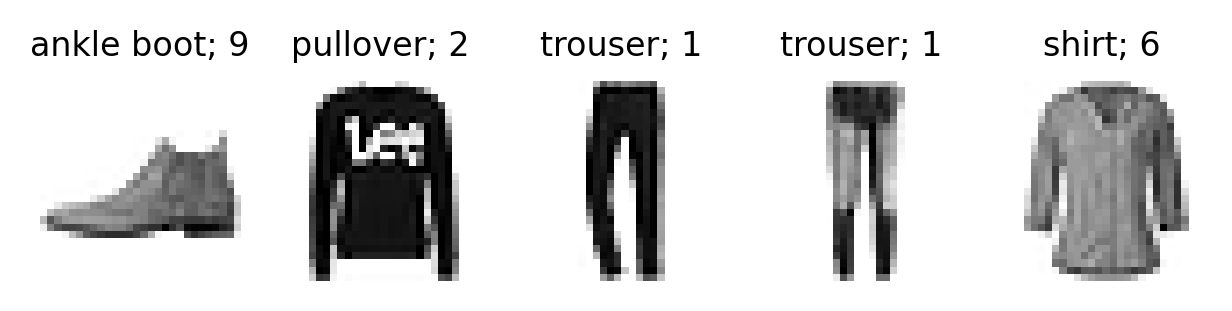

the label is 9; the prediction is 9
the label is 2; the prediction is 2
the label is 1; the prediction is 1
the label is 1; the prediction is 1
the label is 6; the prediction is 6


In [35]:
# testing the trained model on five image
plt.figure(dpi=300,figsize=(5,1))
for i in range(5):
    ax=plt.subplot(1,5, i + 1)
    img=test_set[i][0]
    label=test_set[i][1]
    img=img/2+0.5
    img=img.reshape(28, 28)
    plt.imshow(img, cmap="binary")
    plt.axis('off')
    plt.title(text_labels[label]+f"; {label}", fontsize=8)
plt.show()
for i in range(5):
    img,label = test_set[i]
    img=img.reshape(-1,28*28).to(device)
    pred=model(img)
    index_pred=torch.argmax(pred,dim=1)
    idx=index_pred.item()
    print(f"the label is {label}; the prediction is {idx}")

In [36]:
# testing the trained multicategory classification model
results=[]

for imgs,labels in test_loader:
    imgs=imgs.reshape(-1,28*28).to(device)
    labels=(labels).reshape(-1,).to(device)
    preds=model(imgs)
    pred10=torch.argmax(preds,dim=1)
    correct=(pred10==labels)
    results.append(correct.detach().cpu().numpy().mean())
    
accuracy=np.array(results).mean()
print(f"the accuracy of the predictions is {accuracy}")

the accuracy of the predictions is 0.884156050955414
